In [48]:
import json
import pandas as pd


data_file = '/content/split_file_0.jsonl'

rows = []
with open(data_file, 'r') as f:
    for line in f:
        record = json.loads(line.strip())
        num = record['num']
        target = int(record['target'])
        for shingle in record['shingles']:
            rows.append({'shingle': shingle, 'target': target})

df = pd.DataFrame(rows)

output_file = 'processed_shingles.csv'
df.to_csv(output_file, index=False)


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

class ShingleDataset(Dataset):
    def __init__(self, data, input_dim=130):
        self.data = data
        self.input_dim = input_dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        shingle_ids = [int(s) for s in item['shingle_id']]

        input_ids = torch.zeros(self.input_dim, dtype=torch.float32)
        input_ids[:len(shingle_ids)] = torch.tensor(shingle_ids[:self.input_dim], dtype=torch.float32)

        label = int(item['target'])
        return {'input_ids': input_ids, 'label': torch.tensor(label, dtype=torch.long)}

In [51]:
file_paths = ['/content/split_file_0.jsonl']
dataframes = []
for file_path in file_paths:
    data = pd.read_json(file_path, lines=True)
    reshaped_data = [{'shingle_id': row['shingles'], 'target': int(row['target'])} for _, row in data.iterrows()]
    reshaped_df = pd.DataFrame(reshaped_data)
    dataframes.append(reshaped_df)

full_data = pd.concat(dataframes, ignore_index=True)

train_data = full_data.sample(frac=0.8, random_state=42)
val_data = full_data.drop(train_data.index)

train_dataset = ShingleDataset(train_data)
val_dataset = ShingleDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [53]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

class AutoencoderClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        logits = self.classifier(encoded)
        return logits, reconstructed


In [54]:
model = AutoencoderClassifier(input_dim=130, hidden_dim=64)
criterion_reconstruction = nn.MSELoss()
criterion_classification = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/100
Train Loss: 8094845851999928.0000, Accuracy: 81.0000, Precision: 0.1341, Recall: 0.1387, ROC AUC: 51.5054
Validation Loss: 8534715695345172.0000, Accuracy: 84.8125, Precision: 0.1892, Recall: 0.1207, ROC AUC: 52.8788
Epoch 2/100
Train Loss: 7978938850019901.0000, Accuracy: 81.6562, Precision: 0.1699, Recall: 0.1792, ROC AUC: 53.6512
Validation Loss: 8878581938609193.0000, Accuracy: 43.0625, Precision: 0.1059, Recall: 0.5690, ROC AUC: 49.1355
Epoch 3/100
Train Loss: 8242207832817009.0000, Accuracy: 81.4062, Precision: 0.1680, Recall: 0.1821, ROC AUC: 53.6380
Validation Loss: 8665147170766193.0000, Accuracy: 88.7500, Precision: 0.2000, Recall: 0.0115, ROC AUC: 50.2942
Epoch 4/100
Train Loss: 7907064545993032.0000, Accuracy: 80.9844, Precision: 0.1569, Recall: 0.1734, ROC AUC: 53.0206
Validation Loss: 8481315864979702.0000, Accuracy: 88.0625, Precision: 0.2703, Recall: 0.0575, ROC AUC: 51.9269
Epoch 5/100
Train Loss: 8033705247039816.0000, Accuracy: 80.9531, Precision: 0.1376,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 8603325242393231.0000, Accuracy: 89.1250, Precision: 0.0000, Recall: 0.0000, ROC AUC: 50.0000
Epoch 19/100
Train Loss: 8200668601615647.0000, Accuracy: 81.6406, Precision: 0.1584, Recall: 0.1618, ROC AUC: 52.8805
Validation Loss: 8662448669657661.0000, Accuracy: 84.9375, Precision: 0.1927, Recall: 0.1207, ROC AUC: 52.9489
Epoch 20/100
Train Loss: 8067389949424435.0000, Accuracy: 81.6875, Precision: 0.1657, Recall: 0.1720, ROC AUC: 53.3512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 8562375370630758.0000, Accuracy: 89.1250, Precision: 0.0000, Recall: 0.0000, ROC AUC: 50.0000
Epoch 21/100
Train Loss: 7927424749708247.0000, Accuracy: 81.1250, Precision: 0.1692, Recall: 0.1908, ROC AUC: 53.8613
Validation Loss: 8569974617328845.0000, Accuracy: 87.8750, Precision: 0.2500, Recall: 0.0575, ROC AUC: 51.8217
Epoch 22/100
Train Loss: 8002264212753613.0000, Accuracy: 81.3906, Precision: 0.1605, Recall: 0.1705, ROC AUC: 53.1213
Validation Loss: 8460358639167734.0000, Accuracy: 32.0000, Precision: 0.1153, Recall: 0.7874, ROC AUC: 52.5165
Epoch 23/100
Train Loss: 7933284332150456.0000, Accuracy: 81.3594, Precision: 0.1610, Recall: 0.1720, ROC AUC: 53.1673
Validation Loss: 8409576078657454.0000, Accuracy: 83.0000, Precision: 0.1818, Recall: 0.1609, ROC AUC: 53.6280
Epoch 24/100
Train Loss: 8074662565201838.0000, Accuracy: 81.3438, Precision: 0.1662, Recall: 0.1806, ROC AUC: 53.5395
Validation Loss: 8521105118467195.0000, Accuracy: 87.8750, Precision: 0.1667, Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 9670870121148580.0000, Accuracy: 89.1250, Precision: 0.0000, Recall: 0.0000, ROC AUC: 50.0000
Epoch 61/100
Train Loss: 8141547136614400.0000, Accuracy: 81.1719, Precision: 0.1501, Recall: 0.1590, ROC AUC: 52.4907
Validation Loss: 8442094682657260.0000, Accuracy: 86.5625, Precision: 0.1940, Recall: 0.0747, ROC AUC: 51.8422
Epoch 62/100
Train Loss: 7968864113021420.0000, Accuracy: 81.1719, Precision: 0.1501, Recall: 0.1590, ROC AUC: 52.4907
Validation Loss: 8370595194386514.0000, Accuracy: 88.1875, Precision: 0.1429, Recall: 0.0172, ROC AUC: 50.2309
Epoch 63/100
Train Loss: 7848706018178499.0000, Accuracy: 81.1562, Precision: 0.1460, Recall: 0.1532, ROC AUC: 52.2280
Validation Loss: 8369274465099448.0000, Accuracy: 39.1875, Precision: 0.1056, Recall: 0.6149, ROC AUC: 48.9799
Epoch 64/100
Train Loss: 8301934988199199.0000, Accuracy: 81.7656, Precision: 0.1769, Recall: 0.1879, ROC AUC: 54.0935
Validation Loss: 9030538579473858.0000, Accuracy: 66.5625, Precision: 0.0870, Re

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 8477943276807127.0000, Accuracy: 89.1250, Precision: 0.0000, Recall: 0.0000, ROC AUC: 50.0000
Epoch 79/100
Train Loss: 8111584931374694.0000, Accuracy: 81.3125, Precision: 0.1490, Recall: 0.1546, ROC AUC: 52.3791
Validation Loss: 8640556697900810.0000, Accuracy: 80.8125, Precision: 0.1444, Recall: 0.1552, ROC AUC: 52.1485
Epoch 80/100
Train Loss: 7922163432386724.0000, Accuracy: 81.0781, Precision: 0.1431, Recall: 0.1503, ROC AUC: 52.0572
Validation Loss: 8320988287221105.0000, Accuracy: 87.8125, Precision: 0.2162, Recall: 0.0460, ROC AUC: 51.2820
Epoch 81/100
Train Loss: 7935331684004659.0000, Accuracy: 80.8906, Precision: 0.1511, Recall: 0.1662, ROC AUC: 52.6505
Validation Loss: 8544971049140224.0000, Accuracy: 88.3125, Precision: 0.1579, Recall: 0.0172, ROC AUC: 50.3011
Epoch 82/100
Train Loss: 8043791696548332.0000, Accuracy: 81.2812, Precision: 0.1534, Recall: 0.1618, ROC AUC: 52.6790
Validation Loss: 8546950132489257.0000, Accuracy: 80.7500, Precision: 0.1616, Re

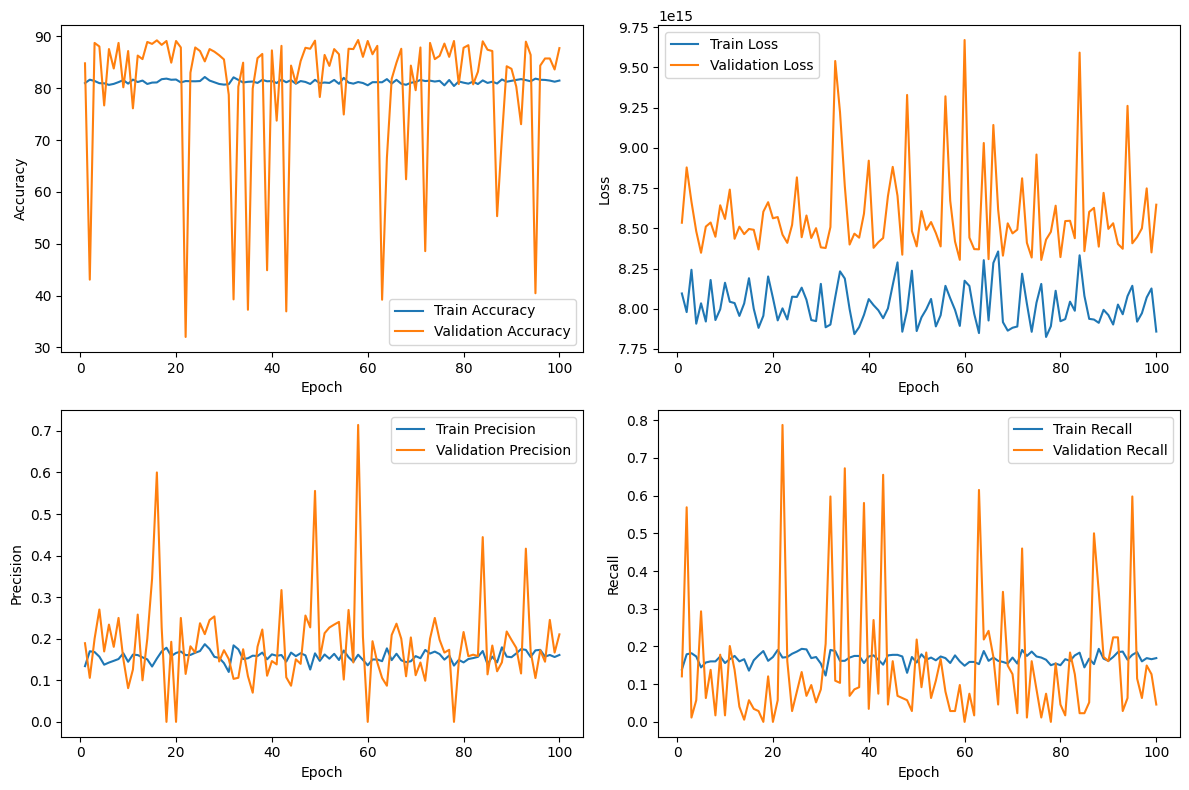

In [65]:
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_roc_aucs, val_roc_aucs = [], []

num_epochs = 100
epochs = list(range(1, num_epochs + 1))

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    all_labels, all_preds = [], []

    for batch in train_loader:
        inputs, labels = batch['input_ids'], batch['label']
        optimizer.zero_grad()

        logits, reconstructed = model(inputs)
        loss_reconstruction = criterion_reconstruction(reconstructed, inputs)
        loss_classification = criterion_classification(logits, labels)
        loss = loss_reconstruction + loss_classification

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_roc_auc = roc_auc_score(all_labels, all_preds)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy * 100)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_roc_aucs.append(train_roc_auc * 100)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f}, "
          f"Accuracy: {train_accuracies[-1]:.4f}, "
          f"Precision: {train_precisions[-1]:.4f}, "
          f"Recall: {train_recalls[-1]:.4f}, "
          f"ROC AUC: {train_roc_aucs[-1]:.4f}")

    model.eval()
    val_loss, all_val_labels, all_val_preds = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input_ids'], batch['label']
            logits, reconstructed = model(inputs)

            loss_reconstruction = criterion_reconstruction(reconstructed, inputs)
            loss_classification = criterion_classification(logits, labels)
            loss = loss_reconstruction + loss_classification
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)
    val_roc_auc = roc_auc_score(all_val_labels, all_val_preds)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy * 100)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_roc_aucs.append(val_roc_auc * 100)

    print(f"Validation Loss: {val_losses[-1]:.4f}, "
          f"Accuracy: {val_accuracies[-1]:.4f}, "
          f"Precision: {val_precisions[-1]:.4f}, "
          f"Recall: {val_recalls[-1]:.4f}, "
          f"ROC AUC: {val_roc_aucs[-1]:.4f}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()
